# Driver Lifetime Value
source: https://platform.stratascratch.com/data-projects/driver-lifetime-value

### Assumptions
(1) The data is from 2016-03 to 2026-06. It is typically not enough duration to observe the life time of the driver. However, given limited data, I assume the life time of all drivers are observed within this period

(2) Without knowing how much revenue is paid back to the driver, I assumn the life time value of the driver is the total revenue generated by the driver

In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [244]:
driver = pd.read_csv("./datasets/driver_ids.csv")
ride = pd.read_csv("./datasets/ride_ids.csv")
ridets = pd.read_csv("./datasets/ride_timestamps.csv")

print(driver.info())
print(ride.info())
print(ridets.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   driver_id            937 non-null    object
 1   driver_onboard_date  937 non-null    object
dtypes: object(2)
memory usage: 14.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   driver_id        193502 non-null  object
 1   ride_id          193502 non-null  object
 2   ride_distance    193502 non-null  int64 
 3   ride_duration    193502 non-null  int64 
 4   ride_prime_time  193502 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     -

### (1) Feature engineering

In [245]:
# Pivot ride timestamps
ridets["timestamp"] = pd.to_datetime(ridets["timestamp"])
ridets_pivot = (
    ridets.pivot(index="ride_id", columns="event", values="timestamp")
    .reset_index()
    .assign(
        request_to_accept=lambda x: (x.accepted_at - x.requested_at).dt.total_seconds(),
        pickup_to_dropoff=lambda x: (x.dropped_off_at - x.picked_up_at)
        / pd.Timedelta(minutes=1),
    )
)


In [246]:
# Merge driver, ride and ride_ts
trips = ride.merge(ridets_pivot, on="ride_id", how="inner", validate="1:1").merge(
    driver, on="driver_id", how="inner", validate="m:1"
)
print(f"{driver.shape=} {ride.shape=} {ridets_pivot.shape=} {trips.shape=}")

driver.shape=(937, 2) ride.shape=(193502, 5) ridets_pivot.shape=(194081, 8) trips.shape=(184209, 13)


In [247]:
# Calculate fares
trips = trips.assign(
    bare_fare=lambda x: (
        2 + 0.22 * x.ride_duration / 60 + 1.15 * x.ride_distance / 1609.34
    )
    * (100 + x.ride_prime_time)
    / 100
    + 1.75,
    final_fare=lambda x: np.minimum(400, np.maximum(5, x.bare_fare)),
)


In [248]:
print(f"{trips.driver_onboard_date.min()=}")
print(f"{trips.dropped_off_at.max()=}")

trips.driver_onboard_date.min()='2016-03-28 00:00:00'
trips.dropped_off_at.max()=Timestamp('2016-06-27 00:50:50')


In [249]:
trips.columns

Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'accepted_at', 'arrived_at', 'dropped_off_at',
       'picked_up_at', 'requested_at', 'request_to_accept',
       'pickup_to_dropoff', 'driver_onboard_date', 'bare_fare', 'final_fare'],
      dtype='object')

In [303]:
# Active days
# Total trips
# Total distance
# Total duration
# Total prime time
# Total fare
# Tenure
# pct_active
# Average trips per day
# Average distance per day
# Average duration per day
# Average distance per trip
# Average prime time per day
# Average speed
# Dominant working hours: Morning, Afternoon, Evening, Night

driveragg = (
    trips.assign(
        active_date=lambda x: x.accepted_at.dt.date,
        driver_onboard_date=lambda x: pd.to_datetime(x.driver_onboard_date),
        tenure=lambda x: (pd.to_datetime("2016-06-30") - x.driver_onboard_date).dt.days,
        prime_trip=lambda x: np.where(x.ride_prime_time > 0, 1, 0),
    )
    .groupby(["driver_id", "tenure"], as_index=False)
    .agg(
        driver_onboard_date=("driver_onboard_date", "min"),
        active_days=("active_date", "nunique"),
        last_active_day=("accepted_at", "max"),
        total_trips=("ride_id", "nunique"),
        total_distance=("ride_distance", "sum"),
        total_duration=("ride_duration", "sum"),
        total_fare=("final_fare", "sum"),
        total_prime=("ride_prime_time", "sum"),
        total_prime_trip=("prime_trip", "sum"),
    )
    .assign(
        lifetime=lambda x: (x.last_active_day - x.driver_onboard_date).dt.days,
        pct_active=lambda x: x.active_days / x.tenure,
        pct_prime=lambda x: x.total_prime_trip / x.total_trips,
        trips_pday=lambda x: x.total_trips / x.active_days,
        distance_pday=lambda x: x.total_distance / x.active_days,
        duration_pday=lambda x: x.total_duration / x.active_days,
        distance_ptrip=lambda x: x.total_distance / x.total_trips,
        prime_pday=lambda x: x.total_prime / x.active_days,
        fare_ptenure=lambda x: x.total_fare / x.tenure,
    )
)

In [304]:
driveragg.columns

Index(['driver_id', 'tenure', 'driver_onboard_date', 'active_days',
       'last_active_day', 'total_trips', 'total_distance', 'total_duration',
       'total_fare', 'total_prime', 'total_prime_trip', 'lifetime',
       'pct_active', 'pct_prime', 'trips_pday', 'distance_pday',
       'duration_pday', 'distance_ptrip', 'prime_pday', 'fare_ptenure'],
      dtype='object')

### (2) Driver lifetime value

In [305]:
driveragg.total_fare.mean()

2979.8596114979996

### (3) Average life time

In [306]:
print(f"{driveragg.lifetime.mean()} days")

55.075268817204304 days


### (3) CATGBM to predict total lifetime value

In [307]:
target = "total_fare"
predictors = ["pct_active", "pct_prime", "trips_pday", "distance_ptrip"]

,pct_active,pct_prime,trips_pday,distance_ptrip
pct_active,1.000000,0.279598,0.470902,-0.041977
pct_prime,0.279598,1.000000,0.275588,-0.361159
trips_pday,0.470902,0.275588,1.000000,-0.280506
distance_ptrip,-0.041977,-0.361159,-0.280506,1.000000


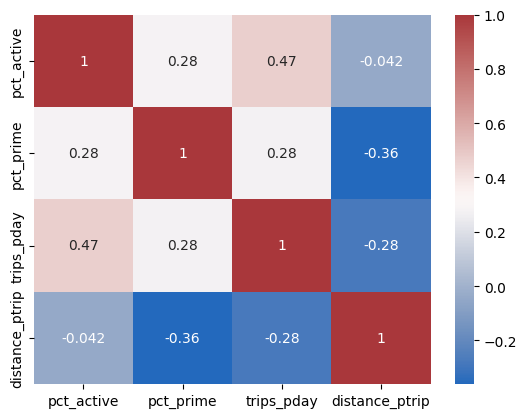

In [308]:
preddf = driveragg[predictors]
corrmap = preddf.corr()
sns.heatmap(corrmap, cmap="vlag", annot=True)
corrmap

In [309]:
X = driveragg[predictors]
y = driveragg[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
y_train

282    4100.583778
430     543.200357
764     542.102253
209    4226.801934
157    2662.386650
          ...     
71      267.662452
599    7099.476603
571    6366.270135
815     590.789067
103     550.079624
Name: total_fare, Length: 585, dtype: float64

In [310]:
mdl = CatBoostRegressor(
    n_estimators=20000,
    learning_rate=0.01,
    early_stopping_rounds=100,
    random_state=777,
)

model1 = mdl.fit(X=X_train, y=y_train, eval_set=(X_test, y_test))

0:	learn: 2417.9335319	test: 2355.5509926	best: 2355.5509926 (0)	total: 2.45ms	remaining: 49.1s
1:	learn: 2402.0895056	test: 2340.2844615	best: 2340.2844615 (1)	total: 4.12ms	remaining: 41.2s
2:	learn: 2384.6312241	test: 2322.9589227	best: 2322.9589227 (2)	total: 5.51ms	remaining: 36.7s
3:	learn: 2365.6073072	test: 2304.3424845	best: 2304.3424845 (3)	total: 6.99ms	remaining: 35s
4:	learn: 2347.6902556	test: 2287.2787371	best: 2287.2787371 (4)	total: 8.32ms	remaining: 33.3s
5:	learn: 2329.4819394	test: 2270.0207282	best: 2270.0207282 (5)	total: 9.55ms	remaining: 31.8s
6:	learn: 2311.5282016	test: 2253.1730265	best: 2253.1730265 (6)	total: 10.8ms	remaining: 30.9s
7:	learn: 2294.0398346	test: 2236.3516515	best: 2236.3516515 (7)	total: 11.9ms	remaining: 29.7s
8:	learn: 2279.3095542	test: 2223.5149125	best: 2223.5149125 (8)	total: 13.7ms	remaining: 30.5s
9:	learn: 2261.8730002	test: 2206.8976662	best: 2206.8976662 (9)	total: 15.1ms	remaining: 30.2s
10:	learn: 2245.0953768	test: 2190.9422654

In [311]:
fi_df = pd.DataFrame({"features": predictors, "score": model1.get_feature_importance()})
fi_df.sort_values("score", ascending=False)

,features,score
0,pct_active,59.263220
2,trips_pday,29.626988
3,distance_ptrip,7.144870
1,pct_prime,3.964922


In [323]:
driveragg.columns

Index(['driver_id', 'tenure', 'driver_onboard_date', 'active_days',
       'last_active_day', 'total_trips', 'total_distance', 'total_duration',
       'total_fare', 'total_prime', 'total_prime_trip', 'lifetime',
       'pct_active', 'pct_prime', 'trips_pday', 'distance_pday',
       'duration_pday', 'distance_ptrip', 'prime_pday', 'fare_ptenure'],
      dtype='object')

<Axes: xlabel='pct_prime', ylabel='total_fare'>

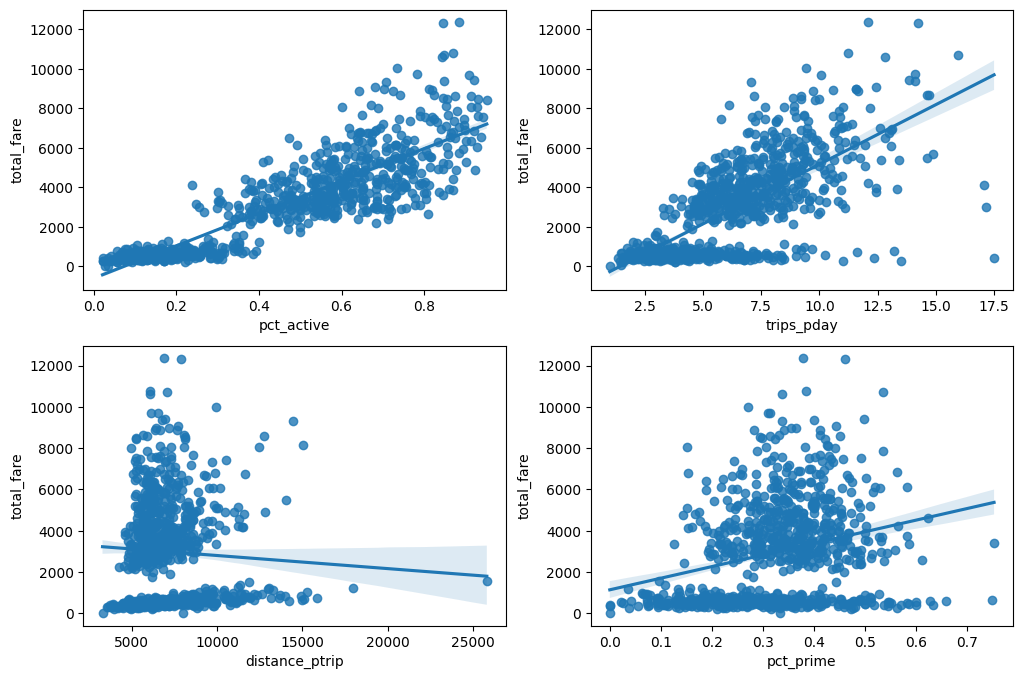

In [340]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
sns.regplot(data=driveragg, x="pct_active", y="total_fare", ax=ax[0, 0])
sns.regplot(driveragg, x="trips_pday", y="total_fare", ax=ax[0, 1])
sns.regplot(driveragg, x="distance_ptrip", y="total_fare", ax=ax[1, 0])
sns.regplot(driveragg, x="pct_prime", y="total_fare", ax=ax[1, 1])